In [2]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import binned_statistic_2d

In [3]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

### Star formation histories

In [4]:
def bin_sfr(t, sfr, bin_width=0.01):
    bin_left = 0.0
    bin_right = bin_left + bin_width
    
    ave_sfr = []
    ave_t = []
    
    max_val = np.max(t)
    while bin_left < max_val:
        key = np.logical_and(t >=bin_left, t<bin_right)
        ave_sfr.append(np.mean(sfr[key]))
        ave_t.append(np.mean(t[key]))
        
        bin_left += bin_width
        bin_right += bin_width
        
    return np.array(ave_t), np.array(ave_sfr)

(0.0, 1.0)

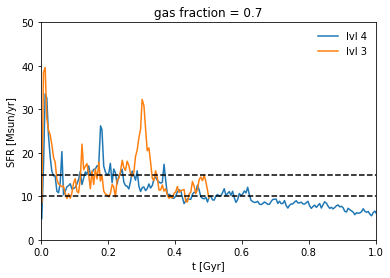

In [27]:
bin_width = 0.005

sfh_file = np.genfromtxt(basepath+'runs/MW3iso_fg0.7_MHG0.1_RC30/lvl4/output/sfr.txt')
time, sfr = bin_sfr(sfh_file[:,0], sfh_file[:,2], bin_width=bin_width)
plt.plot(time, sfr, label='lvl 4')

sfh_file_l3 = np.genfromtxt(basepath+'runs/MW3iso_fg0.7_MHG0.1_RC30/lvl3/output/sfr.txt')
time_l3, sfr_l3 = bin_sfr(sfh_file_l3[:,0], sfh_file_l3[:,2], bin_width=bin_width)
plt.plot(time_l3, sfr_l3, label='lvl 3')

# sfh_file_l2 = np.genfromtxt(basepath+'runs/MW3iso_fg0.7/lvl2/output/sfr.txt')
# time_l2, sfr_l2 = bin_sfr(sfh_file_l2[:,0], sfh_file_l2[:,2], bin_width=bin_width)
# plt.plot(time_l2, sfr_l2, label='lvl 2')

plt.legend(frameon=False)
plt.xlabel('t [Gyr]')
plt.ylabel('SFR [Msun/yr]')
plt.title('gas fraction = 0.7')
plt.axhline(10, c='k', ls='dashed')
plt.axhline(15, c='k', ls='dashed')
# plt.axvline(0.005*25)
plt.ylim(0, 50)
plt.xlim(0, 1)

(0.0, 2.0)

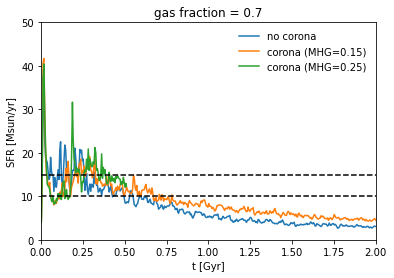

In [6]:
bin_width = 0.005

sfh_file = np.genfromtxt(basepath+'runs/MW3iso_fg0.7/lvl4/output/sfr.txt')
time, sfr = bin_sfr(sfh_file[:,0], sfh_file[:,2], bin_width=bin_width)
plt.plot(time, sfr, label='no corona')

sfh_file_l3 = np.genfromtxt(basepath+'runs/MW3iso_fg0.7_MHG0.15_RC9/lvl4/output/sfr.txt')
time_l3, sfr_l3 = bin_sfr(sfh_file_l3[:,0], sfh_file_l3[:,2], bin_width=bin_width)
plt.plot(time_l3, sfr_l3, label='corona (MHG=0.15)')

sfh_file_l3 = np.genfromtxt(basepath+'runs/MW3iso_fg0.7_MHG0.25_RC9/lvl4/output/sfr.txt')
time_l3, sfr_l3 = bin_sfr(sfh_file_l3[:,0], sfh_file_l3[:,2], bin_width=bin_width)
plt.plot(time_l3, sfr_l3, label='corona (MHG=0.25)')

# sfh_file_l2 = np.genfromtxt(basepath+'runs/MW3iso_fg0.7/lvl2/output/sfr.txt')
# time_l2, sfr_l2 = bin_sfr(sfh_file_l2[:,0], sfh_file_l2[:,2], bin_width=bin_width)
# plt.plot(time_l2, sfr_l2, label='lvl 2')

plt.legend(frameon=False)
plt.xlabel('t [Gyr]')
plt.ylabel('SFR [Msun/yr]')
plt.title('gas fraction = 0.7')
plt.axhline(10, c='k', ls='dashed')
plt.axhline(15, c='k', ls='dashed')
# plt.axvline(0.005*25)
plt.ylim(0, 50)
plt.xlim(0, 2)

### density profile

In [125]:
sn = {}
num_list = [0, 50, 100, 150, 200]
for num in num_list:
    sn[num] = arepo.Snapshot(basepath + 'runs/MW3iso_fg0.7_MHG0.15_RC9/lvl4/output', num, combineFiles=True)

In [95]:
def compute_dens_profile(sn):
    center = np.array([sn.BoxSize, sn.BoxSize, sn.BoxSize])/2.
    pos = sn.part0.pos.value - center
    
    r = np.linalg.norm(pos, axis=1)
    
    dr = 1.0
    rbin = 0
    rmax = 80
    
    ave_r = []
    ave_dens = []
    
    while rbin < rmax:
        dV = (4*np.pi/3.) * ((rbin+dr)**3 - rbin**3)
        key = np.logical_and(r > rbin, r < rbin + dr)
        mass = np.sum(sn.part0.mass.value[key])
        
        ave_r.append(np.mean(r[key]))
        ave_dens.append(mass/dV)
        
        rbin += dr
    
    return np.array(ave_r), np.array(ave_dens)
    

In [127]:
r = {}
rho = {}
for num in num_list:
    r[num], rho[num] = compute_dens_profile(sn[num])

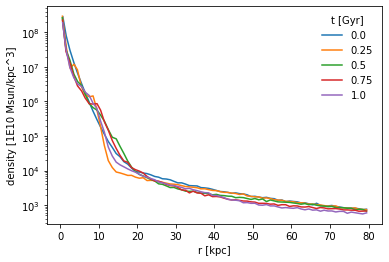

In [131]:
for num in num_list:
    plt.plot(r[num], rho[num]*1E10, label=str(num/200))
plt.legend(frameon=False, title='t [Gyr]')
plt.xlabel('r [kpc]')
plt.ylabel('density [1E10 Msun/kpc^3]')
plt.yscale('log')

### metallicity slices

In [34]:
from scipy.spatial import KDTree
from numba import njit

In [110]:
sn = {}
num_list = [0, 50, 100, 150, 200]

for num in num_list:
    sn[num] = arepo.Snapshot(basepath + 'runs/MW3iso_fg0.7_MHG0.15_RC9/lvl4/output/', 
                             num, combineFiles=True)

In [111]:
nres = 1024

rng = [-80, 80]

@njit
def create_plot_pos(x, y, nres):
    plot_pos = np.zeros((nres*nres, 3))
    for i in range(len(x)):
        for j in range(len(y)):
            plot_pos[i*nres + j][0]=x[i][0]
            plot_pos[i*nres + j][2]=y[0][j]

    return plot_pos

x, z = np.meshgrid(np.linspace(rng[0], rng[1], nres), np.linspace(rng[0], rng[1], nres), indexing='ij')
plot_pos = create_plot_pos(x, z, nres)

In [112]:
center = {}
pos_gas = {}
tree = {}
key = {}

for num in tqdm(num_list):
    center[num] = np.array([sn[num].BoxSize, sn[num].BoxSize, sn[num].BoxSize])/2.
    pos_gas[num] = sn[num].part0.pos.value - center[num]
    

    tree[num] = KDTree(pos_gas[num])
    _, key[num] = tree[num].query(plot_pos)

100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


In [117]:
def compute_T(sn):
    u = sn.part0.InternalEnergy.value
    xe = sn.part0.ElectronAbundance
    
    gamma=5/3
    
    XH = 0.76
    mp = 1.672621911E-24
    mu = 4 * mp / (1 + 3*XH + 4*XH*xe)
    
    kB = 1.381E-16
    
    T = (gamma - 1.) * (u/kB) * 1E10 * mu
    return T

In [118]:
dens_gas = {}
plot_dens = {}
plot_dens_map = {}

metal_gas = {}
plot_metal = {}
plot_metal_map = {}

T_gas = {}
plot_T = {}
plot_T_map = {}

for num in num_list:
    dens_gas[num] = sn[num].part0.rho.value
    plot_dens[num] = dens_gas[num][key[num]]
    plot_dens_map[num] = np.reshape(plot_dens[num], (nres, nres))
    
    metal_gas[num] = sn[num].part0.GFM_Metallicity
    plot_metal[num] = metal_gas[num][key[num]]
    plot_metal_map[num] = np.reshape(plot_metal[num], (nres, nres))
    
    T_gas[num] = compute_T(sn[num])
    plot_T[num] = T_gas[num][key[num]]
    plot_T_map[num] = np.reshape(plot_T[num], (nres, nres))
    
    

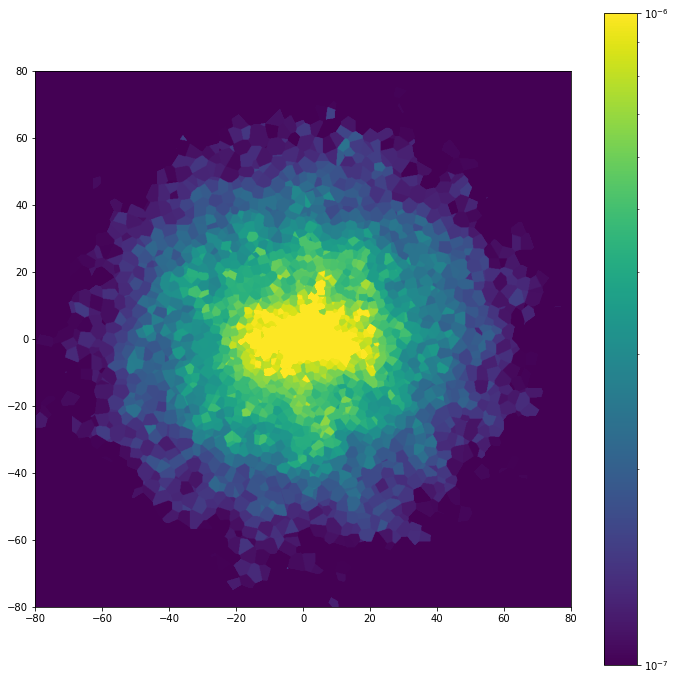

In [114]:
num = 50

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
extent = [rng[0], rng[1], rng[0], rng[1]]
im = ax.imshow(plot_dens_map[num].T, extent=extent, origin='lower', 
               norm=mpl.colors.LogNorm(vmin=1e-7, vmax=1e-6))
fig.colorbar(im, ax=ax)
plt.show()

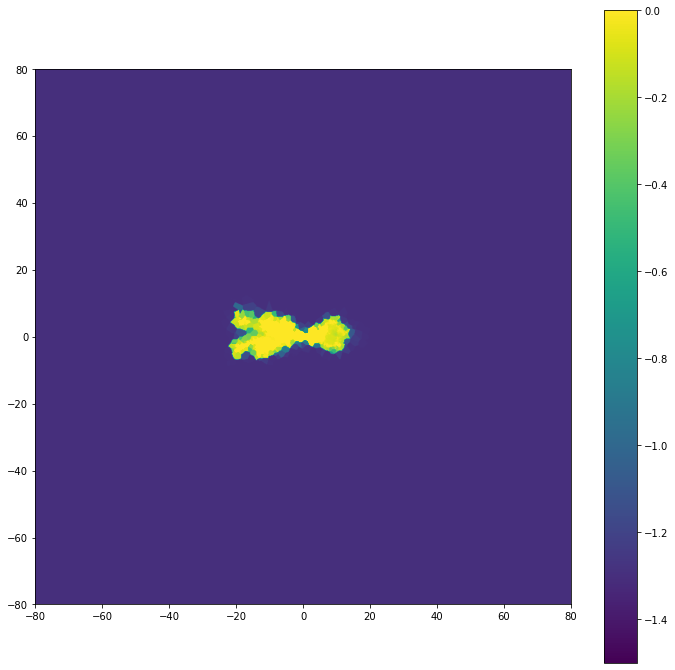

In [122]:
num = 150

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
extent = [rng[0], rng[1], rng[0], rng[1]]
to_map = np.log10(plot_metal_map[num]/0.0127)
im = ax.imshow(to_map.T, extent=extent, origin='lower', 
               vmin=-1.5, vmax=0)
fig.colorbar(im, ax=ax)
plt.show()

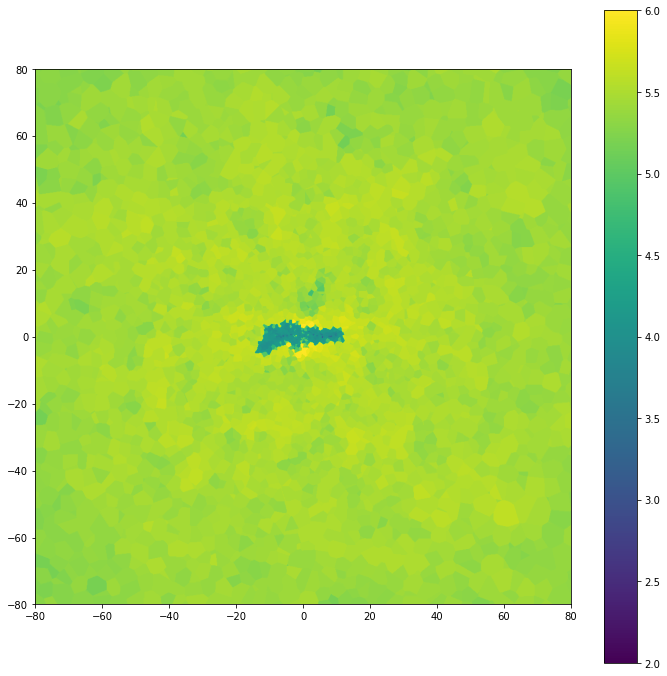

In [121]:
num = 50

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
extent = [rng[0], rng[1], rng[0], rng[1]]
to_map = np.log10(plot_T_map[num])
im = ax.imshow(to_map.T, extent=extent, origin='lower', 
               vmin=2, vmax=6)
fig.colorbar(im, ax=ax)
plt.show()

In [134]:
center = np.array([200, 200, 200])
rgas = np.linalg.norm(sn[0].part0.pos.value - center, axis=1)
rdisk = np.linalg.norm(sn[0].part2.pos.value - center, axis=1)
rhalo = np.linalg.norm(sn[0].part1.pos.value - center, axis=1)

keygas = rgas < 129
keydisk = rdisk < 129
keyhalo = rhalo < 129

massgas = np.sum(sn[0].part0.mass.value[keygas])
massdisk = sn[0].MassTable[2] * sn[0].NumPart_Total[2]
masshalo = len(np.where(keyhalo)[0]) * sn[0].MassTable[1]

print((massgas + massdisk)/masshalo)


0.11653099555932095
